In [ ]:
#importing modules
import numpy as np
import matplotlib.pyplot as plt; plt.ioff()

from astropy.io import fits as pyfits
from astropy import wcs
from astropy.table import Table, join, vstack
from matplotlib.backends.backend_pdf import PdfPages
import pickle
from scipy.optimize import curve_fit

import emcee
import corner 

from os.path import exists
nan= float('nan')

pi= np.pi
e= np.e

plt.close('all')
c= 3.*10**8
h= 6.62*10**-34
k= 1.38*10**-23



PATH='/Users/jansen/My Drive/Astro/'


In [25]:
import pyneb as pn

Flux_halpha = 5.480300076954449e-17
Flux_hbeta = 1.317198265055217e-17

Intrinsic_rat = 2.86

rc = pn.RedCorr(law= 'CCM89', R_V=2.505)
rc.setCorr((Flux_halpha/Flux_hbeta)/Intrinsic_rat, wave1=6563, wave2=4861)


Flux_halpha_cor  = Flux_halpha* rc.getCorr(6563)

print('Av = ', rc.AV)
print('Flux of Halpha corrected for extinction: ', Flux_halpha_cor, 'ergs/s/cm-2')



Av =  1.008596263382641
Flux of Halpha corrected for extinction:  1.1481214090612934e-16 ergs/s/cm-2


## With Bootstrapping

In [64]:
Flux_halpha = 5.480300076954449e-17
Flux_halpha_err = 5.480300076954449e-17/20
Flux_hbeta = 1.317198265055217e-17
Flux_hbeta_err = 1.317198265055217e-17/20

Intrinsic_rat = 2.86

rc = pn.RedCorr(law= 'CCM89', R_V=2.505)


rc.setCorr((np.random.normal(Flux_halpha, Flux_halpha_err, 100)/np.random.normal(Flux_hbeta, Flux_hbeta_err, 100))/Intrinsic_rat, wave1=6563, wave2=4861)


Flux_halpha_cor  = np.random.normal(Flux_halpha, Flux_halpha_err, 100)* rc.getCorr(6563)

print('Av = ', np.median(rc.AV), '+-', np.std(rc.AV))
print('Flux of Halpha corrected for extinction: ', np.mean(Flux_halpha_cor), '+-', np.std(Flux_halpha_cor), 'ergs/s/cm-2')



Av =  1.0132703679748718 +- 0.20550549490986725
Flux of Halpha corrected for extinction:  1.1434764060355305e-16 +- 1.7665907064024363e-17 ergs/s/cm-2


## SFR

In [27]:
redshift = 3.45
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u 
lum = (Flux_halpha_cor*u.erg/u.s/u.cm**2) * 4*np.pi*(cosmo.luminosity_distance(redshift))**2  
lum = lum.to(u.erg/u.s)  # Convert to ergs/s
print('Luminosity', lum,) #'ergs/s')

# SFR calibration in https://ui.adsabs.harvard.edu/abs/2012ARA%26A..50..531K/abstract
# Table 1, page 17 of PDF, 547 of the review
CX = 10**-41.27
SFR = lum.value * CX

print(  'SFR = ', SFR, 'Msun/yr')

Luminosity 1.2989700508875753e+43 erg / s
SFR =  69.75882198593081 Msun/yr


# Metallicities

After you corrected you fluxes for dust obscuration, we can start looking into the metallicities. You can calculate the following emission line rations:

NII6584/Halpha

OIII5007/Hbeta

SII6718,6732/Halpha

You can find the calibration: https://ui.adsabs.harvard.edu/abs/2020MNRAS.491..944C/abstract

You can plot the calibration of line ratio vs metallciity seen in Figure 1 and parameters in Table 2. 

They are polynomials = C0 + c1 X**1 + c2 X**2 + c3 x**3 etc...

You can then estimate the metallicities from the different line ratios - final metallicity should be average of those 3 values with errors as the range. 

You can read it from the plot for now, later on, we should write a minimizer code. 


R3 =  8.449999999999982 log10(Z/Zsun)


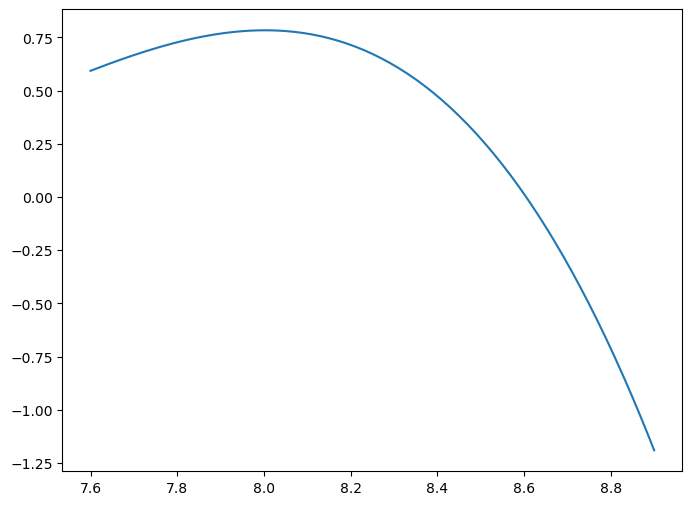

In [54]:
R3_param = [-0.277, -3.549, -3.593,  -0.981]
x_met = np.linspace(7.5,9,100)-8.69

met = np.arange(7.6, 8.9, 0.01)
x = met - 8.69
R3_eval = -0.277 + -3.549*x + -3.593*(x**2) + -0.981*(x**3)
f,ax = plt.subplots(figsize=(8,6))
ax.plot(met, R3_eval, label='R3')

loc_r3 = np.argmin(np.abs(R3_eval - np.log10(3.146370792496217/1.317198265055217)))
print('R3 = ', met[loc_r3], 'log10(Z/Zsun)')

plt.show()